# План домашней работы
1. Реализовать алгоритмы **item2item**, **ALS**, **IALS** (2 балл за каждый)
2. Посчитать метрику предсказаний **MRR@100** выбрасывая случайный лайк пользователя (2 балла)

Будем решать задачу предсказания: на 4/5 пользователей учимся, на 1/5 выбрасываем случайный лайк и пытаемся предсказать его беря топ 100 наших лучших предсказаний для этого пользователя.

MRR@100 будет равно $1/(p+1)$, где $p$ - позиция на которой оказался выброшенный лайк в нашем ранжировании и 0 если в топ 100 его не было.

3. Подобрать параметры алгоритмов для максимизации MRR@100 (1 балл)
4. Сравнить похожести айтемов получаюшиеся для item2item, ALS, IALS (1 балл)

Замерить насколько получаются похожими топы похожестей. Так же рекомендуется взять 5-топовых (или любимых) статей и посмотреть на похожести которые получаются для них в разных алгоритмах.

### Обозначения:
1. item_id - уникальный id айтема (статьи).
2. user_id - уникальный id пользователя.
3. source_id - уникальный id автора. Если у двух айтемов совпадают source_id, то это статьи одного автора.
4. Название айтема - это название статьи.
5. В датасете хранится user_id и список айтемов item_ids, с которыми пользователь положительно провзаимодействовал.

### Ссылки на датасет Дзена:

1. Датасет: https://disk.yandex.ru/d/uUx1MMsZUR87Sw
2. Названия айтемов: https://disk.yandex.ru/d/_ZMXsmki-OtLJA
3. Линки между item_id и source_id: https://disk.yandex.ru/d/GCryohhLbYPFoA

# Разбираемся с датасетом Дзена

In [121]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import spsolve
from sklearn.neighbors import KDTree

In [149]:
all_names = pd.read_json("item_id_to_name.json", lines=False)
item_links = pd.read_json("item_id_to_source_id.json", lines=False)
dataset = pd.read_json("dataset_zen.json", lines=False)

In [150]:
all_names

,id,name
0,94962,Что обычно ожидало русских казачек в руках у к...
1,3972,Почему Россия решила строить новую скоростную ...
2,94644,"5 неприличных фактов об Андрее Макаревиче, кот..."
3,82518,"Что стало с красавицей Хмельницкой, которую му..."
4,53264,"Понять и Простить: Почему угонщики, бежавшие и..."
...,...,...
104498,36769,"Плюс один источник мифа о рыцарях, неспособных..."
104499,9190,Мой сад - малоуходный
104500,52731,Купил первую в жизни циркулярную пилу. Честный...
104501,72660,Решили предложить Марине помощь в лечении ч.10


In [151]:
item_links

,id,source
0,94962,2919814402697966089
1,3972,3263022753228392991
2,94644,-3857390427602554682
3,82518,-9036908390349249792
4,53264,3353856219169766284
...,...,...
104498,36769,3818746211375738614
104499,9190,4975535765688979937
104500,52731,3720366796439288909
104501,72660,-7860042973720636310


In [152]:
dataset

,user_id,item_ids
0,993675863667353526,"[15267, 61075, 81203, 17066, 25471, 88427, 638..."
1,4250619547882954185,"[4555, 94644, 84972, 17774, 94962, 78217, 2485..."
2,3847785305345691076,"[1898, 26703, 16525, 86939, 55017, 31069, 4035..."
3,1785181112918558233,"[75601, 102458, 28716, 100694, 5757, 47104, 60..."
4,5078748097863903181,"[72260, 40825, 2615, 42549, 379, 100818, 56827..."
...,...,...
75905,4954138831959898373,"[11881, 55520, 63054, 48015, 66952, 103830, 21..."
75906,4967793435819938014,"[74697, 11830, 63858, 87245, 41956, 62089, 686..."
75907,7137764184903122777,"[10353, 1775, 103680, 29704, 9782, 13295, 9975..."
75908,2624987805086334956,"[24324, 18854, 73319, 66641, 64078, 97387, 426..."


In [164]:
dataset['len'] = dataset['item_ids'].map(len)

In [165]:
dataset = dataset[dataset['len'] > 0]

In [142]:
print(user_item_matrix[0].toarray())

[[-0.00038276 -0.00038276 -0.00038276 ... -0.00038276 -0.00038276
  -0.00038276]]


In [166]:
total_interactions_count = dataset.item_ids.map(len).sum()
user_coo = np.zeros(total_interactions_count, dtype=np.int64)
item_coo = np.zeros(total_interactions_count, dtype=np.int64)
pos = 0

for user_id, item_ids in enumerate(tqdm(dataset.item_ids)):
    user_coo[pos:pos+len(item_ids)] = user_id
    item_coo[pos:pos+len(item_ids)] = item_ids
    pos += len(item_ids)
shape = (max(user_coo) + 1, max(item_coo) + 1)
user_item_matrix = sp.coo_matrix((np.ones(len(user_coo)), (user_coo, item_coo)), shape=shape)
user_item_matrix = user_item_matrix.tocsr()
sp.save_npz("data_train.npz", user_item_matrix)
# Cleanup memory. Later you need just data_train.npz
del user_coo
del item_coo
del dataset

  0%|          | 0/75905 [00:00<?, ?it/s]

In [168]:
user_item_matrix = sp.load_npz("data_train.npz")

In [169]:
user_item_matrix[0]

<1x104503 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [170]:
user_item_matrix.shape

(75905, 104503)

In [171]:
n_user = user_item_matrix.shape[0]
n_items = user_item_matrix.shape[1]

In [172]:
item_weights = np.array(user_item_matrix.tocsc().sum(0))[0]
top_to_bottom_order = np.argsort(-item_weights)
item_mapping = np.empty(top_to_bottom_order.shape, dtype=int)
item_mapping[top_to_bottom_order] = np.arange(len(top_to_bottom_order))
total_item_count = (item_weights > 0).sum()
total_user_count = user_item_matrix.shape[0]

def build_dataset(user_item_matrix, item_pct, user_pct):
    user_count, item_count = int(total_user_count * user_pct), int(total_item_count * item_pct)
    item_ids = top_to_bottom_order[:item_count]
    user_ids = np.random.choice(np.arange(user_item_matrix.shape[0]), size=user_count, replace=False)
    train = user_item_matrix[user_ids]
    train = train[:, item_ids]
    return train

*** Здесь начинается мой код ***
Начинаем с разделения данных на тренировочные и тестовые, в тестовых сразу выкидываем один рандомный лайк пользователя и сохраняем его позицию для последующего расчета метрик. Также из тестовой выборки исключаются результаты с одним лайком так как при его выкидывании мы получаем проблему холодного старта, результаты для таких пользователей могут отличаться от других


In [398]:
def split_train_test(user_item_matrix, user_pct):
    user_count = int(total_user_count * user_pct)
    user_ids = np.random.choice(np.arange(user_item_matrix.shape[0]), size=user_count, replace=False)
    train = user_item_matrix[user_ids]
    test = []
    for i in range(user_item_matrix.shape[0]):
        if i not in user_ids:
            arr = user_item_matrix[i].copy()
            one_indexes =  arr.nonzero()[1]
            if len(one_indexes) <= 1:
                continue
            rand_ind =  np.random.choice(one_indexes, size=1, replace=False)[0]
            arr[0, rand_ind] = 0
            test.append((arr, rand_ind))
    return train, test

In [399]:
train, test = split_train_test(user_item_matrix, 0.8)

In [400]:
print(f"train shape is {train.shape}")
print(f"test len is {len(test)}")

train shape is (60724, 104503)
test len is 15179


Классы алгоритмов  item2item, ALS и IALS, метод predict_and_metrics отвечает за предсказание MRR@100 на данных без случайного лайка

In [401]:
from sklearn.neighbors import NearestNeighbors
class Item2Item:
    def __init__(self):
        self.item_similarities = NearestNeighbors(metric='cosine', n_neighbors=100, n_jobs=-1)
        self.emb_mat = None

    def fit(self, ratings_matrix):
        self.item_similarities.fit(ratings_matrix.T)
        self.emb_mat = ratings_matrix.T

    def get_k_closest(self, list_of_items, pos_to_look = None):
        sub_matr = self.emb_mat[list_of_items]
        dist, neigh = self.item_similarities.kneighbors(sub_matr, n_neighbors = 100)
        neigh = np.ravel(neigh)
        dist = np.ravel(dist)
        dist_list = list(zip(list(dist), list(neigh)))
        dist_list = sorted(dist_list)
        ans = []
        min_pos  = 0
        for x in dist_list:
            if len(ans) == 100:
                return min_pos
            if x[1] == pos_to_look and min_pos == 0:
                min_pos = 1 / (len(ans) + 1)
            if  x[1] not in list_of_items:
                list_of_items.append(x[1])
                ans.append(x)
        return min_pos
    
    def predict_and_metrics(self, items_arr, rand_ind = None):
        one_indexes = list(items_arr.nonzero()[1])
        metric = self.get_k_closest(one_indexes, rand_ind)
        return metric    


In [471]:
class ALS:
    def __init__(self, n_iters = 8, n_factors = 43, reg = 0.1):
        self.reg = reg
        self.n_iters = n_iters
        self.n_factors = n_factors  
        
    def fit(self, train):
        self.n_user, self.n_item = train.shape
        self.user_factors = np.random.random((self.n_user, self.n_factors))
        self.item_factors = np.random.random((self.n_item, self.n_factors))
  
        for _ in range(self.n_iters):
            self.user_factors = self._als_step(train, self.user_factors, self.item_factors)
            self.item_factors = self._als_step(train.T, self.item_factors, self.user_factors) 
        return self    
    
    def _als_step(self, ratings, solve_vecs, fixed_vecs):
        A = fixed_vecs.T.dot(fixed_vecs) + np.eye(self.n_factors) * self.reg
        b = ratings.dot(fixed_vecs)
        A_inv = np.linalg.inv(A)
        solve_vecs = b.dot(A_inv)
        return solve_vecs
    
    def predict(self, user_id, item_id):
        return self.user_factors[user_id].dot(self.item_factors[item_id].T)
    
    def get_k_closest(self, user_id, top_n):
        scores = self.user_factors[user_id].dot(self.item_factors.T)
        top_items = np.argsort(scores)[::-1][:top_n]
        return top_items
    
    def predict_and_metrics(self, items_arr, rand_ind = None):
        arr = items_arr
        user_factor = self._als_step(arr, [], self.item_factors)
        user_rec = user_factor.dot(self.item_factors.T)
        top_items = np.argsort(user_rec)[::-1][:100][0]
        for i in range(100):
            if top_items[i] == rand_ind:
                return 1 / (i + 1)
        return 0

        

In [469]:
class IALS:
    def __init__(self, n_iters = 5, n_factors = 10, alpha = 15, reg = 0.01, seed = 42):
        self.reg = reg
        self.seed = seed
        self.alpha = alpha
        self.n_iters = n_iters
        self.n_factors = n_factors
    
    def fit(self, ratings):
        Cui = ratings.copy()
        Cui.data *= self.alpha
        Ciu = Cui.T.tocsr()
        self.n_users, self.n_items = Cui.shape
        rstate = np.random.RandomState(self.seed)
        self.user_factors = rstate.normal(size = (self.n_users, self.n_factors))
        self.item_factors = rstate.normal(size = (self.n_items, self.n_factors))
        
        for _ in range(self.n_iters):
            self._als_step(Cui, self.user_factors, self.item_factors)
            self._als_step(Ciu, self.item_factors, self.user_factors)  
        
        return self
    
    def _als_step(self, Cui, X, Y):
        YtY = Y.T.dot(Y)
        data = Cui.data
        indptr, indices = Cui.indptr, Cui.indices
        for u in range(self.n_users):
            b = np.zeros(self.n_factors)
            A = YtY + self.reg * np.eye(self.n_factors)            
            for index in range(indptr[u], indptr[u + 1]):
                i = indices[index]
                confidence = data[index] + 1
                factor = Y[i]
                b += confidence * factor
                A += (confidence - 1) * np.outer(factor, factor)
            X[u] = np.linalg.solve(A, b)
        return self

    def predict(self, user_id, item_id):
        return self.user_factors[user_id].dot(self.item_factors[item_id].T)
    
    def get_k_closest(self, user_id, top_n):
        scores = self.user_factors[user_id].dot(self.item_factors.T)
        top_items = np.argsort(scores)[::-1][:top_n]
        return top_items
    
    def predict_and_metrics(self, items_arr, rand_ind = None):
        Cui = items_arr.copy()
        Cui.data *= self.alpha
        Ciu = Cui.T.tocsr()
        rstate = np.random.RandomState(self.seed)
        X = rstate.normal(size = (1, self.n_factors))
        Y = self.item_factors
        YtY = Y.T.dot(Y)
        data = Cui.data
        indptr, indices = Cui.indptr, Cui.indices
        b = np.zeros(self.n_factors)
        A = YtY + self.reg * np.eye(self.n_factors)          
        for index in range(indptr[0], indptr[1]):
            i = indices[index]
            confidence = data[index] + 1
            factor = Y[i]
            b += confidence * factor
            A += (confidence - 1) * np.outer(factor, factor)
        user_factor = np.linalg.solve(A, b)
        user_rec = user_factor.dot(self.item_factors.T)
        top_items = np.argsort(user_rec)[::-1][:100]
        for i in range(100):
            if top_items[i] == rand_ind:
                return 1 / (i + 1)
        return 0

Процедура обучения всех трех алгоритов, несмотря на то что item2item быстро обучался, предсказывает он не очень быстро, так как для каждого пользовательского лайка он ищет 100 похожих и уже из этих 100 рекомендаций для каждого лайка выбирает 100 общих рекомендаций для всех(самые близкие). Эту операцию можно оптимизировать, если построить матрицу расстояний между статьями (будет весить больше чем исходная useritem и считаться не очень быстро),но это могло бы ускорить предсказания, так как тогда мы бы искали ближайшие статьи сразу к множеству статей. 

In [455]:
import time
algos = {"item2item": Item2Item(), "ALS" : ALS(), "IALS":IALS()}
algo_names = ["item2item","ALS", "IALS"]
for algo in algo_names:
    start_time = time.perf_counter()
    print(f"training {algo}")
    algos[algo].fit(train)  
    end_time = time.perf_counter()
    print(f"{algo} trained in {round(end_time - start_time, 3)}s")

training item2item
item2item trained in 0.466s
training ALS
ALS trained in 42.647s
training IALS
IALS trained in 1832.516s


In [473]:
metrics_algo = {"item2item": [], "ALS" : [], "IALS": []}

In [477]:
start_time = time.perf_counter()
for i in range(len(metrics_algo['ALS']),len(test)):
    if i % 100 == 0 and i > 0:
        end_time = time.perf_counter()
        print(f"iteration #{i}")
        for algo in algo_names:
            print(f"{algo} MRR@100 mean is = {np.mean(metrics_algo[algo])}")
        print(f"test epoch in {round(end_time - start_time, 3)}s")
        print(f"----------------------------------")
        start_time = time.perf_counter()
    
    test_rank = test[i][0]
    rand_like = test[i][1]
    for algo in algo_names:
        metric = algos[algo].predict_and_metrics(test_rank, rand_like)
        metrics_algo[algo].append(metric)

iteration #1000
item2item MRR@100 mean is = 0.011465797188828957
ALS MRR@100 mean is = 0.0005
IALS MRR@100 mean is = 0.008054748748195091
test epoch in 0.001s
----------------------------------
iteration #1100
item2item MRR@100 mean is = 0.011311383520251577
ALS MRR@100 mean is = 0.00045454545454545455
IALS MRR@100 mean is = 0.009188139096151637
test epoch in 150.924s
----------------------------------
iteration #1200
item2item MRR@100 mean is = 0.010773630406149702
ALS MRR@100 mean is = 0.0004166666666666667
IALS MRR@100 mean is = 0.009154982259804502
test epoch in 142.929s
----------------------------------
iteration #1300
item2item MRR@100 mean is = 0.01032547163632882
ALS MRR@100 mean is = 0.000576923076923077
IALS MRR@100 mean is = 0.008756664393376055
test epoch in 158.101s
----------------------------------
iteration #1400
item2item MRR@100 mean is = 0.010036032272973892
ALS MRR@100 mean is = 0.0005357142857142857
IALS MRR@100 mean is = 0.008422490929656565
test epoch in 154.212

In [478]:
for algo in algo_names:
        print(f"{algo} MRR@100 mean is = {np.mean(metrics_algo[algo])}")

item2item MRR@100 mean is = 0.011395099761210536
ALS MRR@100 mean is = 0.0005134979256144068
IALS MRR@100 mean is = 0.011005787975512493


Подбор оптимальных параметров продемонстрирую на алгоритме ALS, так как он является наиболее удачным соотношением времени обучения и предсказания, а также он располагает несколькими параметрами для оптимизации: количесво итераций алгоритма, количество факторов и регуляризация. Подбор параметров будем осуществлять семплированием: на каждой итерации алгоритма генерировать параметры из диапазона и запускать на них алгоритм. 

In [ ]:
metrics_res = []

In [480]:
import random 

N_SAMPLES = 30
for i in range(len(metrics_res), N_SAMPLES):
    n_iters =  random.randint(1, 30)
    n_factors = random.randint(3, 300)
    reg = random.uniform(0, 0.5)
    test_als = ALS(n_iters = n_iters, n_factors = n_factors, reg = reg)
    test_als.fit(train)
    metrics = np.mean([test_als.predict_and_metrics(test[i][0], test[i][1]) for i in range(1000)])
    print(f"For ALS with n_iters = {n_iters}, n_factors = {n_factors}, reg = {reg} MRR@100 = {metrics}")
    metrics_res.append((n_iters, n_factors, reg, metrics))

For ALS with n_iters = 15, n_factors = 209, reg = 0.4418803712450309 MRR@100 = 0.00019493112147489928
For ALS with n_iters = 25, n_factors = 264, reg = 0.2722550201004517 MRR@100 = 0.00026452033764063834
For ALS with n_iters = 2, n_factors = 171, reg = 0.0046277357778635175 MRR@100 = 0.0009236401741197138
For ALS with n_iters = 10, n_factors = 68, reg = 0.007130354338744704 MRR@100 = 0.00014048836965503632
For ALS with n_iters = 9, n_factors = 270, reg = 0.10832074340866382 MRR@100 = 0.00023742321039114318
For ALS with n_iters = 20, n_factors = 59, reg = 0.4098368949254231 MRR@100 = 0.0011111111111111111
For ALS with n_iters = 18, n_factors = 118, reg = 0.18666749655800569 MRR@100 = 0.0011786129568106313
For ALS with n_iters = 27, n_factors = 199, reg = 0.13055612883552942 MRR@100 = 0.00029318722290945363
For ALS with n_iters = 2, n_factors = 275, reg = 0.14718271978628644 MRR@100 = 0.0012530177666656794
For ALS with n_iters = 20, n_factors = 48, reg = 0.3819251128248797 MRR@100 = 0.00

In [481]:
for item in metrics_res:
    n_iters, n_factors, reg, metrics = item
    print(f"For ALS with n_iters = {n_iters}, n_factors = {n_factors}, reg = {reg} MRR@100 = {metrics}")

For ALS with n_iters = 4, n_factors = 36, reg = 0.13832617220189963 MRR@100 = 0.0002596530224993223
For ALS with n_iters = 10, n_factors = 87, reg = 0.3152082802206461 MRR@100 = 0.0010882468229080706
For ALS with n_iters = 9, n_factors = 56, reg = 0.1446980303168146 MRR@100 = 8.001675743611229e-05
For ALS with n_iters = 9, n_factors = 12, reg = 0.3653233920185074 MRR@100 = 0.0
For ALS with n_iters = 8, n_factors = 43, reg = 0.10372937081431632 MRR@100 = 0.00175
For ALS with n_iters = 25, n_factors = 24, reg = 0.07850073135978586 MRR@100 = 0.0
For ALS with n_iters = 30, n_factors = 98, reg = 0.2827089986555021 MRR@100 = 0.0011397072585059235
For ALS with n_iters = 16, n_factors = 27, reg = 0.4097270449791149 MRR@100 = 0.0
For ALS with n_iters = 5, n_factors = 72, reg = 0.08286086992444391 MRR@100 = 2.5e-05
For ALS with n_iters = 6, n_factors = 79, reg = 0.08823661138805777 MRR@100 = 0.00020791221357259094
For ALS with n_iters = 22, n_factors = 21, reg = 0.49327631312434517 MRR@100 = 0.0

Результаты разные , лучшая метрика 0.00175, что все равно далеко от item2item, скорее всего из-за недообученных эмбедингов новых пользователей, на обучающих данных результат метрик примерно схож с item2item

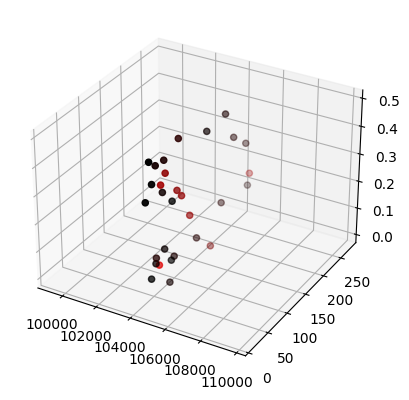

In [486]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = []
Y = []
Z = []
C = []
for item in metrics_res:
    n_iters, n_factors, reg, metrics = item
    X.append(n_items)
    Y.append(n_factors)
    Z.append(reg)
    C.append([metrics * 500, 0, 0])
ax.scatter(X, Y, Z, c = C)